In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
np.set_printoptions(precision=4)

In [3]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, cbar = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    if cbar == True:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Try for one thirds ratio, but with softer constraint

In [15]:
train_X = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one thirds/train_X.npy")
train_Y = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one thirds/train_Y.npy")

true_label = np.zeros((len(train_Y), 1), dtype = '<U10')
for i in range(len(train_Y)):
    true_label[i] = (str(train_Y[i,0])+', '+ str(train_Y[i, 1]))

In [16]:
boa = [25., 30.]
freq = [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

s = np.where((train_Y[:,0] == 25.) & (train_Y[:,1] == 0.3))

Data_split = [] # split the data into categories, to create the library.

i = 0


for b in boa:
    for f in freq:
        s = np.where((train_Y[:,0] == b) & (train_Y[:,1] == f))
        if s[0].shape[0] == 0:
            print(b, f)
            break
        print(b,f, ' : category', i)
        i += 1
        Data_split.append(train_X[s])

25.0 0.05  : category 0
25.0 0.1  : category 1
25.0 0.2  : category 2
25.0 0.25  : category 3
25.0 0.3  : category 4
25.0 0.35  : category 5
25.0 0.4  : category 6
25.0 0.5  : category 7
30.0 0.05  : category 8
30.0 0.1  : category 9
30.0 0.2  : category 10
30.0 0.25  : category 11
30.0 0.3  : category 12
30.0 0.35  : category 13
30.0 0.4  : category 14
30.0 0.5  : category 15


In [17]:
rPODeach = 10 # rPODeach = 10 is feasible for 1/15 ratio.

size = 40000

Library = np.empty((size,0))

for cat in range(16):
    DataVecsTrain = np.zeros((size, len(Data_split[cat])))

    for i, d in enumerate(Data_split[cat]):
        DataVecsTrain[:,i] = d.reshape(-1)
        
    U, S, Vt = np.linalg.svd(DataVecsTrain, full_matrices = False)
    Library = np.column_stack((Library, U[:,:rPODeach]))

In [22]:
nModesSparse = 2*8*rPODeach

answers = []

testing_number = 100 # takes too long to test for every case. testing for only 100 cases

for i in range(testing_number):
    s = cp.Variable(nModesSparse)
    objective = cp.Minimize(cp.norm(s, 1) + 100*cp.norm(Library @ s - train_X[i].reshape(-1), 2))
    prob = cp.Problem(objective)
    # prob.solve(solver = 'ECOS', verbose = True)
    prob.solve(solver = cp.MOSEK, verbose = False)
    
    answers.append(s.value)

In [23]:
# print(answer)
predictions = []

for answer in answers:
    
    l2each = []
    for i in range(len(answer)):
        if i%rPODeach == 0:
            l2each.append(sum(abs(answer[i:i + rPODeach])))
    l2each = np.array(l2each)
    pred = np.argmax(l2each)
    predictions.append(categories[pred])

# print("l2 norms for each categories :\n", l2each)
# print("\nprediction based on largest norm :", categories[pred])
# print("true label :", Y)

print(classification_report(true_label[:testing_number], predictions, zero_division = 0))

              precision    recall  f1-score   support

  25.0, 0.05       1.00      1.00      1.00         1
   25.0, 0.1       1.00      1.00      1.00         3
   25.0, 0.2       1.00      1.00      1.00         8
  25.0, 0.25       0.83      1.00      0.91         5
   25.0, 0.3       1.00      1.00      1.00         3
  25.0, 0.35       1.00      1.00      1.00         4
   25.0, 0.4       1.00      1.00      1.00         5
   25.0, 0.5       1.00      1.00      1.00         3
  30.0, 0.05       1.00      0.33      0.50         6
   30.0, 0.1       0.67      0.67      0.67         3
   30.0, 0.2       1.00      1.00      1.00        15
  30.0, 0.25       1.00      1.00      1.00         8
   30.0, 0.3       1.00      1.00      1.00         4
  30.0, 0.35       0.80      0.89      0.84        18
   30.0, 0.4       0.75      0.75      0.75         4
   30.0, 0.5       0.91      1.00      0.95        10

    accuracy                           0.92       100
   macro avg       0.93   

Confusion matrix, without normalization


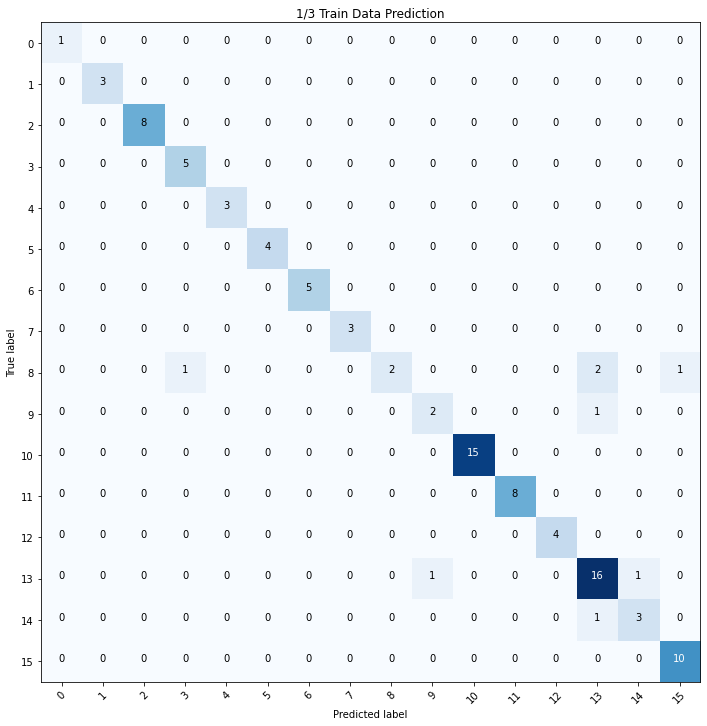

In [25]:
cnf_matrix = confusion_matrix(true_label[:testing_number], predictions)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes = categories, normalize=False,
                      title='1/3 Train Data Prediction')
plt.show()

## Try on Test Data

In [26]:
train_X = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one thirds/test_X.npy")
train_Y = np.load("/Volumes/KleeFD/dataset/window_normalized/Window Size/one thirds/test_Y.npy")

true_label = np.zeros((len(train_Y), 1), dtype = '<U10')
for i in range(len(train_Y)):
    true_label[i] = (str(train_Y[i,0])+', '+ str(train_Y[i, 1]))

In [27]:
nModesSparse = 2*8*rPODeach

answers = []

testing_number = 50 # takes too long to test for every case. testing for only 100 cases

for i in range(testing_number):
    s = cp.Variable(nModesSparse)
    objective = cp.Minimize(cp.norm(s, 1) + 100*cp.norm(Library @ s - train_X[i].reshape(-1), 2))
    prob = cp.Problem(objective)
    # prob.solve(solver = 'ECOS', verbose = True)
    prob.solve(solver = cp.MOSEK, verbose = False)
    
    answers.append(s.value)

              precision    recall  f1-score   support

  25.0, 0.05       1.00      1.00      1.00         2
   25.0, 0.1       1.00      1.00      1.00         2
   25.0, 0.2       1.00      1.00      1.00         1
  25.0, 0.25       1.00      1.00      1.00         2
   25.0, 0.3       1.00      1.00      1.00         1
   25.0, 0.4       1.00      1.00      1.00         4
   25.0, 0.5       1.00      1.00      1.00         1
  30.0, 0.05       1.00      0.25      0.40         4
   30.0, 0.1       0.50      0.33      0.40         3
   30.0, 0.2       1.00      1.00      1.00         1
  30.0, 0.25       1.00      1.00      1.00         6
   30.0, 0.3       1.00      1.00      1.00         7
  30.0, 0.35       0.71      0.71      0.71         7
   30.0, 0.4       0.56      1.00      0.71         5
   30.0, 0.5       1.00      1.00      1.00         4

    accuracy                           0.86        50
   macro avg       0.92      0.89      0.88        50
weighted avg       0.89   

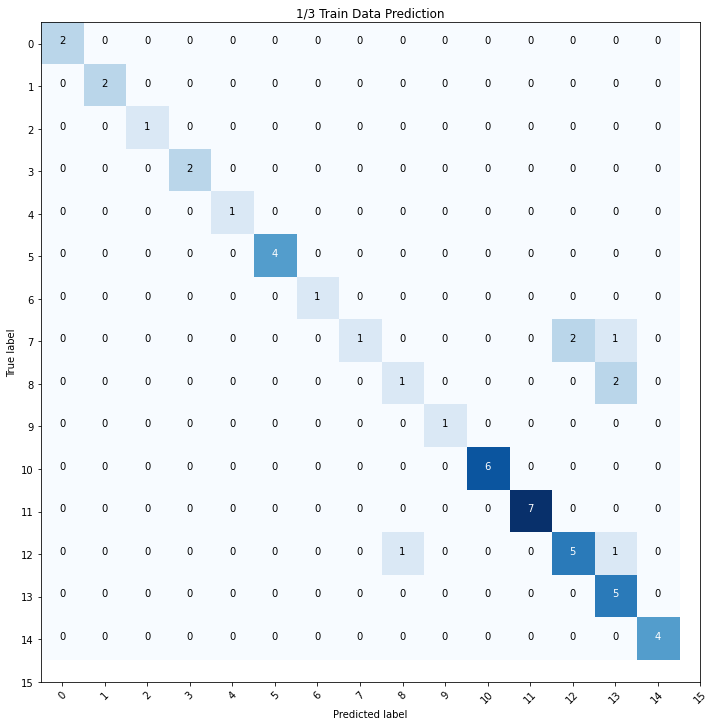

In [28]:
# print(answer)
predictions = []

for answer in answers:
    
    l2each = []
    for i in range(len(answer)):
        if i%rPODeach == 0:
            l2each.append(sum(abs(answer[i:i + rPODeach])))
    l2each = np.array(l2each)
    pred = np.argmax(l2each)
    predictions.append(categories[pred])

# print("l2 norms for each categories :\n", l2each)
# print("\nprediction based on largest norm :", categories[pred])
# print("true label :", Y)

print(classification_report(true_label[:testing_number], predictions, zero_division = 0))

cnf_matrix = confusion_matrix(true_label[:testing_number], predictions)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes = categories, normalize=False,
                      title='1/3 Train Data Prediction')
plt.show()

In [33]:
nModesSparse = 2*8*rPODeach

answers = []

testing_number = 50 # takes too long to test for every case. testing for only 100 cases

s = cp.Variable(nModesSparse)
# Make input image parameter, to solve problem without initializing problem everytime
X = cp.Parameter((size))

objective = cp.Minimize(cp.norm(s, 1) + 100*cp.norm(Library @ s - X, 2))

prob = cp.Problem(objective)


for i in range(testing_number):
    
    X.value = train_X[i].reshape(-1)
    prob.solve(solver = cp.MOSEK, verbose = False)
    
    answers.append(s.value)

              precision    recall  f1-score   support

  25.0, 0.05       1.00      1.00      1.00         2
   25.0, 0.1       1.00      1.00      1.00         2
   25.0, 0.2       1.00      1.00      1.00         1
  25.0, 0.25       1.00      1.00      1.00         2
   25.0, 0.3       1.00      1.00      1.00         1
   25.0, 0.4       1.00      1.00      1.00         4
   25.0, 0.5       1.00      1.00      1.00         1
  30.0, 0.05       1.00      0.25      0.40         4
   30.0, 0.1       0.50      0.33      0.40         3
   30.0, 0.2       1.00      1.00      1.00         1
  30.0, 0.25       1.00      1.00      1.00         6
   30.0, 0.3       1.00      1.00      1.00         7
  30.0, 0.35       0.71      0.71      0.71         7
   30.0, 0.4       0.56      1.00      0.71         5
   30.0, 0.5       1.00      1.00      1.00         4

    accuracy                           0.86        50
   macro avg       0.92      0.89      0.88        50
weighted avg       0.89   

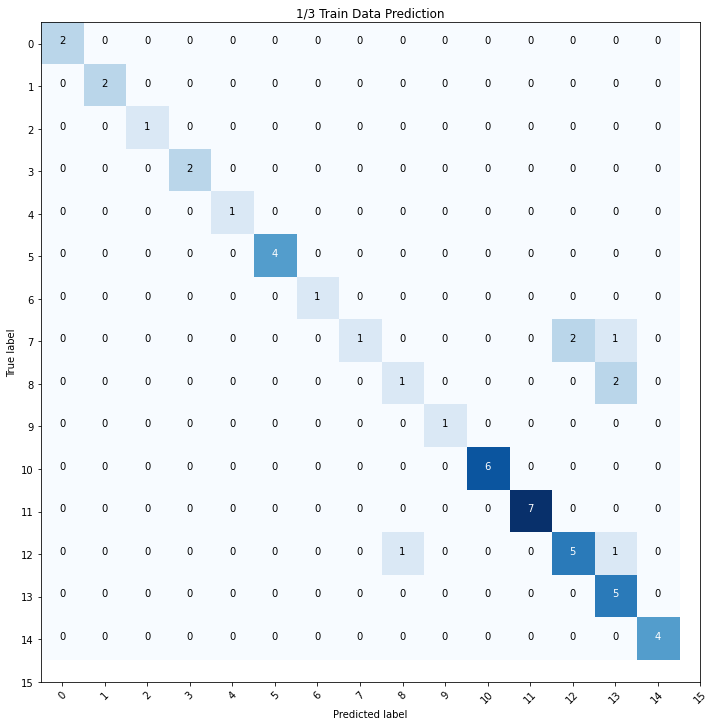

In [34]:
# print(answer)
predictions = []

for answer in answers:
    
    l2each = []
    for i in range(len(answer)):
        if i%rPODeach == 0:
            l2each.append(sum(abs(answer[i:i + rPODeach])))
    l2each = np.array(l2each)
    pred = np.argmax(l2each)
    predictions.append(categories[pred])

# print("l2 norms for each categories :\n", l2each)
# print("\nprediction based on largest norm :", categories[pred])
# print("true label :", Y)

print(classification_report(true_label[:testing_number], predictions, zero_division = 0))

cnf_matrix = confusion_matrix(true_label[:testing_number], predictions)

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes = categories, normalize=False,
                      title='1/3 Train Data Prediction')
plt.show()